Update 20.12.2017.3 - introduced early stopping for LightGBM & updated LightGBM params

Update 21.12.2017 - Introduced stacking & ensemble

Udate 02.01.2018 - restarted working on EDA

Update 09.01.2018 - working on feature generation

Update 15.01.2018 - working on feature hyperparameter optimization

# Final project: predict future sales

This challenge serves as final project for the "How to win a data science competition" Coursera course.
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'), compression='gzip')
test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

# EDA

Shape of the loaded dataframes

In [3]:
print ('sales shape %s' % np.str(sales.shape))
print ('items shape %s' % np.str(items.shape))
print ('item_categories shape %s' % np.str(item_categories.shape))
print ('shops shape %s' % np.str(shops.shape))
print ('train shape %s' % np.str(train.shape))
print ('test shape %s' % np.str(test.shape))

sales shape (2935849, 6)
items shape (22170, 3)
item_categories shape (84, 2)
shops shape (60, 2)
train shape (2935849, 6)
test shape (214200, 3)


Browse data heads to get an idea of the data

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Note. The negative values in item_cnt_day are returned items

In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


I join the data to get the consolidated base data frame

1st I add category description to the items df

In [10]:
items_merge = pd.merge(left = items, right = item_categories , left_on = 'item_category_id', right_on = 'item_category_id')

In [11]:
print (items_merge.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
2    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
3        ***КОРОБКА (СТЕКЛО)                       D        4   
4  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   

   item_category_id item_category_name  
0                40         Кино - DVD  
1                40         Кино - DVD  
2                40         Кино - DVD  
3                40         Кино - DVD  
4                40         Кино - DVD  


Then I add the category to the items sold

In [12]:
sales_merge = pd.merge(left = sales,right = items_merge, left_on ='item_id', right_on = 'item_id' )

In [13]:
print (sales_merge.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  23.01.2013               0       24    22154       999.0           1.0   
2  20.01.2013               0       27    22154       999.0           1.0   
3  02.01.2013               0       25    22154       999.0           1.0   
4  03.01.2013               0       25    22154       999.0           1.0   

           item_name  item_category_id item_category_name  
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
1  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
2  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
3  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
4  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  


check the time span of the training data

In [14]:
dates_df = pd.to_datetime(sales_merge['date'],format='%d.%m.%Y')
print ('Sale from %s to %s' % (str(dates_df.min()),str(dates_df.max())))

Sale from 2013-01-01 00:00:00 to 2015-10-31 00:00:00


#### Note. 2 years & 10 months of sales data. I need to predict the sales in November 2015

### Missing Data 

In [15]:
# missing values?
sales_merge.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

No missing data, all columns have been populated

I visualize how prices are distributed to understand whether there are some dummy values & outliers.

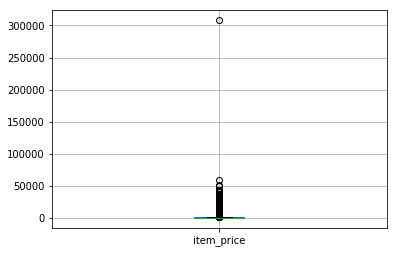

In [16]:
sales_merge.boxplot(column = 'item_price')      

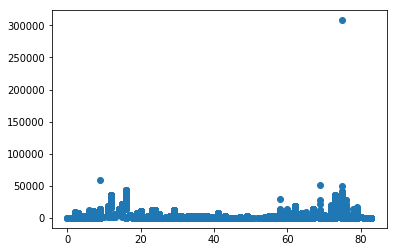

In [17]:
plt.scatter(sales_merge.item_category_id,sales_merge.item_price)
plt.show()

What I did is the following:
* 1st I have checked the prices alone & noticed that most prices are < 100000. 
* Then I have checked the distribution of prices over the item categories & observed that the price > 100000 should be an outlier

Now I quantify the items that are extremely highly priced to confirm I can remove them from the data

In [18]:
sales_merge[sales_merge.item_price > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
2163826,13.12.2013,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [19]:
sales_merge[sales_merge.item_category_id == 75]['item_price'].mean()

1859.8670734734765

#### Note. The high price is probably a typo. I updated the data with the mean

In [20]:
sales_merge.at[2163826, 'item_price'] = 1859

In [21]:
sales_merge.iloc[2163826]

date                                    13.12.2013
date_block_num                                  11
shop_id                                         12
item_id                                       6066
item_price                                    1859
item_cnt_day                                     1
item_name                     Radmin 3  - 522 лиц.
item_category_id                                75
item_category_name    Программы - Для дома и офиса
Name: 2163826, dtype: object

## Gaio Data Cleansing

In [22]:
sales.at[2163826, 'item_price'] = 1859
sales = sales[sales.item_cnt_day<=1000]

Now I am going to visualize the sales over the train period by grouping the items sold by month

In [23]:
aggrMonth = sales_merge.groupby(['date_block_num'])[['item_cnt_day']].sum()

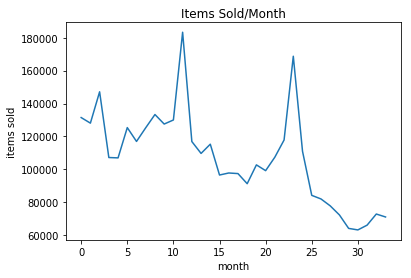

In [24]:
plt.plot(aggrMonth.item_cnt_day)
plt.title ("Items Sold/Month")
plt.xlabel("month") 
plt.ylabel("items sold") 
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

NOTES: 

* There seems to be some seasonality in the sales, with an indication of simmetry.
* We can notice a sharp increase followed by a sharp decrease around the spikes. This can be exploited by adding lagged features.

# Features generation

### Add 1st the test data

In [25]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [26]:
all_data_cols = list(sales)
df_test_append = pd.DataFrame(index=test.index, columns=all_data_cols)
df_test_append = df_test_append.fillna(0)
df_test_append['shop_id'] = test['shop_id']
df_test_append['item_id'] = test['item_id']
df_test_append['date_block_num'] = 34

In [27]:
df_test_append.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,34,5,5037,0,0
1,0,34,5,5320,0,0
2,0,34,5,5233,0,0
3,0,34,5,5232,0,0
4,0,34,5,5268,0,0


In [28]:
sales = pd.concat((sales, df_test_append)).reset_index(drop=True)
print("all_data size is : {}".format(sales.shape))

all_data size is : (3150048, 6)


### Create a DF with all combination of month, shop & item

This is important because in the months we don't have a data for an item store combination, the machine learning algorithm needs to be specifically told that the sales is zero.

In [29]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [30]:
sales_merge = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_merge = pd.merge(grid,sales_merge,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
# adding the category id too
sales_merge = pd.merge(sales_merge,items,on=['item_id'],how='left')

In [31]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


### Create the mean encodings 

In [32]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id,aggregator,aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_merge.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']

        sales_merge = pd.merge(sales_merge,mean_df,on=['date_block_num',type_id],how='left')

In [33]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.800000,18.0,0.400000,97.974472,2017.0,0.248552,63.014719,6094.0,0.199738
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977778,0.0,0.000000,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837778,2.0,0.044444,97.974472,2017.0,0.248552,38.267019,268.0,0.049630
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400000,5.0,0.111111,97.974472,2017.0,0.248552,35.593867,701.0,0.093280


After having create the grid, I add the lags up to 1 year before to leverage the sales seasonality

In [34]:
cols_to_rename = list(sales_merge.columns[7:]) + ['item_cnt_day']
print (cols_to_rename)

['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_cnt_day']


In [35]:
from tqdm import tqdm_notebook

shift_range = [1, 2, 3, 4, 5, 12]

sales_merge = downcast_dtypes(sales_merge)

for month_shift in tqdm_notebook(shift_range):
    print("passa %s\n" % str(month_shift))
    train_shift = sales_merge[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    sales_merge = pd.merge(sales_merge, train_shift, on=index_cols, how='left').fillna(0)
    del train_shift
    
gc.collect();

A Jupyter Widget

passa 1

passa 2

passa 3

passa 4

passa 5

passa 12




In [36]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,...,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_5,item_id_sum_item_cnt_day_lag_5,item_id_avg_item_cnt_day_lag_5,shop_id_avg_item_price_lag_5,shop_id_sum_item_cnt_day_lag_5,shop_id_avg_item_cnt_day_lag_5,item_category_id_avg_item_price_lag_5,item_category_id_sum_item_cnt_day_lag_5,item_category_id_avg_item_cnt_day_lag_5,item_cnt_day_lag_5,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.799988,18.0,0.400000,97.974472,2017.0,0.248552,63.014717,6094.0,0.199738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977777,0.0,0.000000,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837776,2.0,0.044444,97.974472,2017.0,0.248552,38.267017,268.0,0.049630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400002,5.0,0.111111,97.974472,2017.0,0.248552,35.593868,701.0,0.093280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fill NaN with 0

In [37]:
for feat in sales_merge.columns:
    if 'item_cnt' in feat:
        sales_merge[feat]=sales_merge[feat].fillna(0)
    elif 'item_price' in feat:
        sales_merge[feat]=sales_merge[feat].fillna(sales_merge[feat].median())

In [38]:
sales_merge.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,...,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_5,item_id_sum_item_cnt_day_lag_5,item_id_avg_item_cnt_day_lag_5,shop_id_avg_item_price_lag_5,shop_id_sum_item_cnt_day_lag_5,shop_id_avg_item_cnt_day_lag_5,item_category_id_avg_item_price_lag_5,item_category_id_sum_item_cnt_day_lag_5,item_category_id_avg_item_cnt_day_lag_5,item_cnt_day_lag_5,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.799988,18.0,0.400000,97.974472,2017.0,0.248552,63.014717,6094.0,0.199738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977777,0.0,0.000000,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898666,287.0,0.043386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837776,2.0,0.044444,97.974472,2017.0,0.248552,38.267017,268.0,0.049630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400002,5.0,0.111111,97.974472,2017.0,0.248552,35.593868,701.0,0.093280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Drop the columns that I am not going to use for training the model

In [39]:
to_drop_cols = cols_to_rename + ['item_name','item_price']
print (to_drop_cols)

['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_cnt_day', 'item_name', 'item_price']


### Get just recent data

In [40]:
sales_merge = sales_merge[sales_merge['date_block_num']>12]

### Train/Validation/Test split

I will train on the 1st 32 months & validate on the last month

In [41]:
print ('1st month: %s , last month: %s' % (str(sales_merge['date_block_num'].min()),str(sales_merge['date_block_num'].max())))

1st month: 13 , last month: 34


In [42]:
y_train = sales_merge.loc[sales_merge['date_block_num']<33]['item_cnt_day']
y_val =  sales_merge.loc[sales_merge['date_block_num'] == 33]['item_cnt_day']

X_train = sales_merge[sales_merge['date_block_num']<33].drop(to_drop_cols, axis=1)
X_val =  sales_merge[sales_merge['date_block_num']==33].drop(to_drop_cols, axis=1)
X_test = sales_merge[sales_merge['date_block_num']==34].drop(to_drop_cols, axis=1)

X_final_train = sales_merge[sales_merge['date_block_num']<34].drop(to_drop_cols, axis=1)
y_final_train = sales_merge.loc[sales_merge['date_block_num']<34]['item_cnt_day']

### Clip the training target in the range [0,40]

In [43]:
y_train=np.clip(y_train,0, 40)
y_val=np.clip(y_val,0, 40)
y_final_train = np.clip(y_final_train,0, 40)

# Modeling & Stacking

### Define the loss function - RMSE

In [44]:
def rmse(X,y):
    return np.sqrt(mean_squared_error(X, y))

### Select most important features with LightGBM

In [45]:
import lightgbm as lgb
#GAIO Update 20.12.2017.3 - updated lgb params
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }

#GAIO Update 20.12.2017.3 - introduced early stopping having noticed the model overfitting
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

model_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38274
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36713
[3]	valid_0's rmse: 1.35243
[4]	valid_0's rmse: 1.33879
[5]	valid_0's rmse: 1.32609
[6]	valid_0's rmse: 1.31389
[7]	valid_0's rmse: 1.30519
[8]	valid_0's rmse: 1.2958
[9]	valid_0's rmse: 1.28677
[10]	valid_0's rmse: 1.27799
[11]	valid_0's rmse: 1.26858
[12]	valid_0's rmse: 1.25973
[13]	valid_0's rmse: 1.25127
[14]	valid_0's rmse: 1.24517
[15]	valid_0's rmse: 1.23813
[16]	valid_0's rmse: 1.23198
[17]	valid_0's rmse: 1.2258
[18]	valid_0's rmse: 1.21992
[19]	valid_0's rmse: 1.21522
[20]	valid_0's rmse: 1.21084
[21]	valid_0's rmse: 1.20595
[22]	valid_0's rmse: 1.20198
[23]	valid_0's rmse: 1.19775
[24]	valid_0's rmse: 1.19338
[25]	valid_0's rmse: 1.18906
[26]	valid_0's rmse: 1.18551
[27]	valid_0's rmse: 1.18223
[28]	valid_0's rmse: 1.18023
[29]	valid_0's rmse: 1.17693
[30]	valid_0's rmse: 1.17376
[31]	valid_0's rmse: 1.17102
[32]	valid_0's rmse: 1.16804
[33]	valid_0's rmse: 1

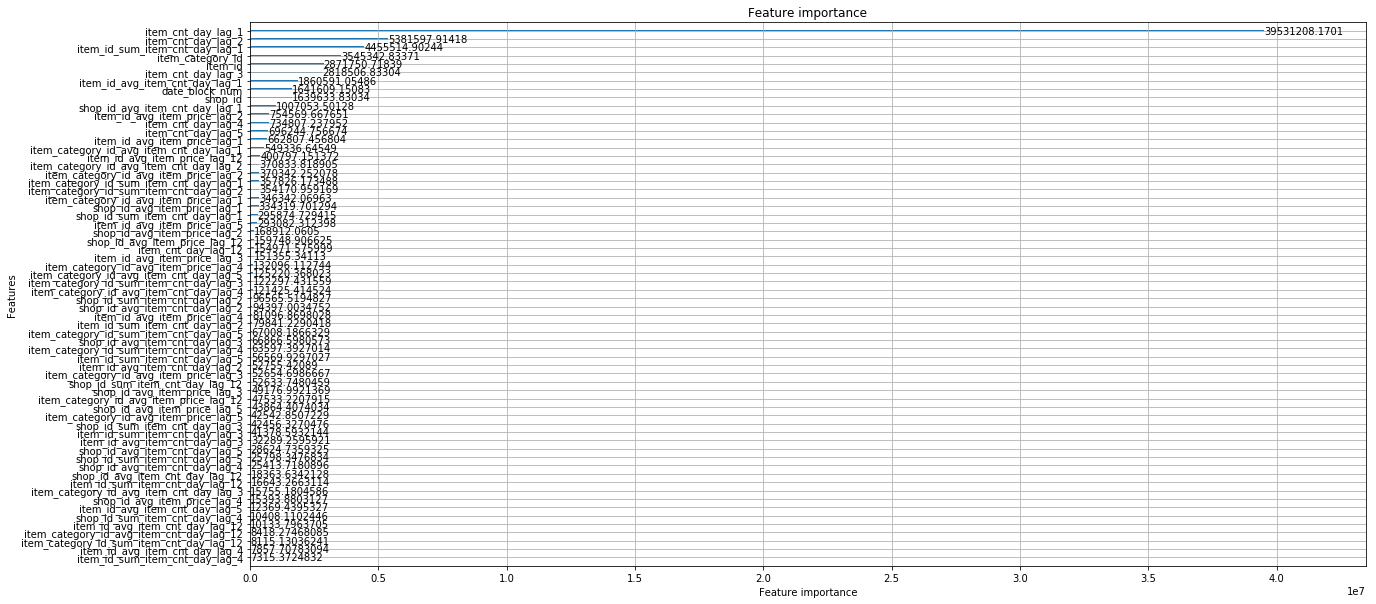

In [46]:
lgb.plot_importance(model_lgb,importance_type='gain')

### Tune LightGBM with Hyperopt

LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can convenge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

To get good results using a leaf-wise tree, these are some important parameters:

* num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to convert from depth-wise tree. However, this simple conversion is not good in practice. The reason is, when number of leaves are the same, the leaf-wise tree is much deeper than depth-wise tree. As a result, it may be over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=6 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise. Actually, the concept depth can be forgotten in leaf-wise tree, since it doesn't have a correct mapping from leaves to depth.
* min_data_in_leaf. This is a very important parameter to deal with over-fitting in leaf-wise tree. Its value depends on the number of training data and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
* max_depth. You also can use max_depth to limit the tree depth explicitly.

In [47]:
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):
    print(space)
    
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'max_depth' : int(space['max_depth']),
               'num_leaves': int(space['num_leaves']),
               'min_data_in_leaf': int(space['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(space['bagging_seed']), 
               'bagging_freq':1,
               'verbose':0,
                'early_stopping_rounds' :1,
                'eval_metric':'rmse'
              }
    opt_lgb = lgb.train(lgb_params,                     
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=5)
    
    pred = opt_lgb.predict(X_val)
    mse_scr = mean_squared_error(y_val, pred)
    print ("SCORE:", np.sqrt(mse_scr))
    return {'loss':mse_scr, 'status': STATUS_OK }

space ={    
    'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 140, 10),
    'bagging_seed': hp.quniform('bagging_seed', 10, 140, 10),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 140, 10)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,            
            trials=trials)

{'bagging_seed': 80.0, 'max_depth': 9.0, 'min_data_in_leaf': 70.0, 'num_leaves': 100.0}


C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38436
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.37132
[3]	valid_0's rmse: 1.3588
[4]	valid_0's rmse: 1.34695
[5]	valid_0's rmse: 1.33502
[6]	valid_0's rmse: 1.32323
[7]	valid_0's rmse: 1.3148
[8]	valid_0's rmse: 1.30526
[9]	valid_0's rmse: 1.29778
[10]	valid_0's rmse: 1.28909
[11]	valid_0's rmse: 1.28004
[12]	valid_0's rmse: 1.27127
[13]	valid_0's rmse: 1.26369
[14]	valid_0's rmse: 1.25729
[15]	valid_0's rmse: 1.24995
[16]	valid_0's rmse: 1.24393
[17]	valid_0's rmse: 1.23809
[18]	valid_0's rmse: 1.23242
[19]	valid_0's rmse: 1.22773
[20]	valid_0's rmse: 1.22249
[21]	valid_0's rmse: 1.21687
[22]	valid_0's rmse: 1.2125
[23]	valid_0's rmse: 1.20773
[24]	valid_0's rmse: 1.20329
[25]	valid_0's rmse: 1.19877
[26]	valid_0's rmse: 1.19533
[27]	valid_0's rmse: 1.19243
[28]	valid_0's rmse: 1.18923
[29]	valid_0's rmse: 1.18607
[30]	valid_0's rmse: 1.18279
[31]	valid_0's rmse: 1.18028
[32]	valid_0's rmse: 1.17738
[33]	valid_0's rmse: 1.

[21]	valid_0's rmse: 1.23728
[22]	valid_0's rmse: 1.2331
[23]	valid_0's rmse: 1.22907
[24]	valid_0's rmse: 1.22506
[25]	valid_0's rmse: 1.22149
[26]	valid_0's rmse: 1.21863
[27]	valid_0's rmse: 1.21589
[28]	valid_0's rmse: 1.21312
[29]	valid_0's rmse: 1.20998
[30]	valid_0's rmse: 1.20697
[31]	valid_0's rmse: 1.20453
[32]	valid_0's rmse: 1.20198
[33]	valid_0's rmse: 1.19955
[34]	valid_0's rmse: 1.19732
[35]	valid_0's rmse: 1.19543
[36]	valid_0's rmse: 1.19328
[37]	valid_0's rmse: 1.19145
[38]	valid_0's rmse: 1.18941
[39]	valid_0's rmse: 1.1876
[40]	valid_0's rmse: 1.18625
[41]	valid_0's rmse: 1.1846
[42]	valid_0's rmse: 1.18311
[43]	valid_0's rmse: 1.18161
[44]	valid_0's rmse: 1.18036
[45]	valid_0's rmse: 1.1791
[46]	valid_0's rmse: 1.17808
[47]	valid_0's rmse: 1.17687
[48]	valid_0's rmse: 1.17567
[49]	valid_0's rmse: 1.17478
[50]	valid_0's rmse: 1.17372
[51]	valid_0's rmse: 1.17275
[52]	valid_0's rmse: 1.17168
[53]	valid_0's rmse: 1.17095
[54]	valid_0's rmse: 1.17001
[55]	valid_0's rms

[14]	valid_0's rmse: 1.25809
[15]	valid_0's rmse: 1.25082
[16]	valid_0's rmse: 1.24461
[17]	valid_0's rmse: 1.23867
[18]	valid_0's rmse: 1.23279
[19]	valid_0's rmse: 1.22804
[20]	valid_0's rmse: 1.222
[21]	valid_0's rmse: 1.21615
[22]	valid_0's rmse: 1.21171
[23]	valid_0's rmse: 1.20668
[24]	valid_0's rmse: 1.20252
[25]	valid_0's rmse: 1.19811
[26]	valid_0's rmse: 1.19493
[27]	valid_0's rmse: 1.19199
[28]	valid_0's rmse: 1.18917
[29]	valid_0's rmse: 1.18569
[30]	valid_0's rmse: 1.18244
[31]	valid_0's rmse: 1.17991
[32]	valid_0's rmse: 1.17703
[33]	valid_0's rmse: 1.17417
[34]	valid_0's rmse: 1.17193
[35]	valid_0's rmse: 1.16934
[36]	valid_0's rmse: 1.16693
[37]	valid_0's rmse: 1.16431
[38]	valid_0's rmse: 1.16201
[39]	valid_0's rmse: 1.15982
[40]	valid_0's rmse: 1.15844
[41]	valid_0's rmse: 1.15664
[42]	valid_0's rmse: 1.15519
[43]	valid_0's rmse: 1.15338
[44]	valid_0's rmse: 1.1519
[45]	valid_0's rmse: 1.15031
[46]	valid_0's rmse: 1.1493
[47]	valid_0's rmse: 1.14798
[48]	valid_0's rms

[95]	valid_0's rmse: 1.14483
Early stopping, best iteration is:
[94]	valid_0's rmse: 1.14479
SCORE: 1.14478926704
{'bagging_seed': 120.0, 'max_depth': 6.0, 'min_data_in_leaf': 120.0, 'num_leaves': 80.0}
[1]	valid_0's rmse: 1.38503
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.37276
[3]	valid_0's rmse: 1.36083
[4]	valid_0's rmse: 1.34954
[5]	valid_0's rmse: 1.33904
[6]	valid_0's rmse: 1.32878
[7]	valid_0's rmse: 1.32122
[8]	valid_0's rmse: 1.31227
[9]	valid_0's rmse: 1.30523
[10]	valid_0's rmse: 1.29693
[11]	valid_0's rmse: 1.28891
[12]	valid_0's rmse: 1.28151
[13]	valid_0's rmse: 1.27428
[14]	valid_0's rmse: 1.26857
[15]	valid_0's rmse: 1.26226
[16]	valid_0's rmse: 1.25641
[17]	valid_0's rmse: 1.25084
[18]	valid_0's rmse: 1.2454
[19]	valid_0's rmse: 1.24113
[20]	valid_0's rmse: 1.23616
[21]	valid_0's rmse: 1.23161
[22]	valid_0's rmse: 1.22747
[23]	valid_0's rmse: 1.22341
[24]	valid_0's rmse: 1.21946
[25]	valid_0's rmse: 1.21573
[26]	valid_0's rmse: 

[54]	valid_0's rmse: 1.13939
[55]	valid_0's rmse: 1.13834
[56]	valid_0's rmse: 1.13727
[57]	valid_0's rmse: 1.13659
[58]	valid_0's rmse: 1.13576
[59]	valid_0's rmse: 1.13556
[60]	valid_0's rmse: 1.13494
[61]	valid_0's rmse: 1.134
[62]	valid_0's rmse: 1.13342
[63]	valid_0's rmse: 1.13317
[64]	valid_0's rmse: 1.13278
[65]	valid_0's rmse: 1.13232
[66]	valid_0's rmse: 1.13198
[67]	valid_0's rmse: 1.13169
[68]	valid_0's rmse: 1.13154
[69]	valid_0's rmse: 1.13119
[70]	valid_0's rmse: 1.13087
[71]	valid_0's rmse: 1.13102
Early stopping, best iteration is:
[70]	valid_0's rmse: 1.13087
SCORE: 1.13086902478
{'bagging_seed': 40.0, 'max_depth': 7.0, 'min_data_in_leaf': 20.0, 'num_leaves': 120.0}
[1]	valid_0's rmse: 1.38454
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.37155
[3]	valid_0's rmse: 1.35949
[4]	valid_0's rmse: 1.34809
[5]	valid_0's rmse: 1.33715
[6]	valid_0's rmse: 1.3267
[7]	valid_0's rmse: 1.31831
[8]	valid_0's rmse: 1.30911
[9]	valid_0's rmse: 1.3

[11]	valid_0's rmse: 1.29991
[12]	valid_0's rmse: 1.29314
[13]	valid_0's rmse: 1.28694
[14]	valid_0's rmse: 1.28217
[15]	valid_0's rmse: 1.27627
[16]	valid_0's rmse: 1.27087
[17]	valid_0's rmse: 1.26558
[18]	valid_0's rmse: 1.26059
[19]	valid_0's rmse: 1.2567
[20]	valid_0's rmse: 1.25196
[21]	valid_0's rmse: 1.24745
[22]	valid_0's rmse: 1.24311
[23]	valid_0's rmse: 1.23902
[24]	valid_0's rmse: 1.23548
[25]	valid_0's rmse: 1.23197
[26]	valid_0's rmse: 1.22911
[27]	valid_0's rmse: 1.2264
[28]	valid_0's rmse: 1.22383
[29]	valid_0's rmse: 1.22089
[30]	valid_0's rmse: 1.21815
[31]	valid_0's rmse: 1.21605
[32]	valid_0's rmse: 1.21353
[33]	valid_0's rmse: 1.21072
[34]	valid_0's rmse: 1.20842
[35]	valid_0's rmse: 1.20667
[36]	valid_0's rmse: 1.20451
[37]	valid_0's rmse: 1.20282
[38]	valid_0's rmse: 1.20095
[39]	valid_0's rmse: 1.19909
[40]	valid_0's rmse: 1.19782
[41]	valid_0's rmse: 1.19633
[42]	valid_0's rmse: 1.19473
[43]	valid_0's rmse: 1.19321
[44]	valid_0's rmse: 1.19166
[45]	valid_0's r

[3]	valid_0's rmse: 1.35398
[4]	valid_0's rmse: 1.3408
[5]	valid_0's rmse: 1.32815
[6]	valid_0's rmse: 1.31643
[7]	valid_0's rmse: 1.30831
[8]	valid_0's rmse: 1.29832
[9]	valid_0's rmse: 1.28919
[10]	valid_0's rmse: 1.28057
[11]	valid_0's rmse: 1.27126
[12]	valid_0's rmse: 1.26242
[13]	valid_0's rmse: 1.25396
[14]	valid_0's rmse: 1.24694
[15]	valid_0's rmse: 1.23966
[16]	valid_0's rmse: 1.23323
[17]	valid_0's rmse: 1.22665
[18]	valid_0's rmse: 1.22028
[19]	valid_0's rmse: 1.21502
[20]	valid_0's rmse: 1.20961
[21]	valid_0's rmse: 1.20396
[22]	valid_0's rmse: 1.19955
[23]	valid_0's rmse: 1.19518
[24]	valid_0's rmse: 1.1907
[25]	valid_0's rmse: 1.18631
[26]	valid_0's rmse: 1.18276
[27]	valid_0's rmse: 1.17928
[28]	valid_0's rmse: 1.17623
[29]	valid_0's rmse: 1.17304
[30]	valid_0's rmse: 1.16931
[31]	valid_0's rmse: 1.16656
[32]	valid_0's rmse: 1.16378
[33]	valid_0's rmse: 1.16121
[34]	valid_0's rmse: 1.15871
[35]	valid_0's rmse: 1.15638
[36]	valid_0's rmse: 1.15406
[37]	valid_0's rmse: 1.

[87]	valid_0's rmse: 1.15757
[88]	valid_0's rmse: 1.15737
[89]	valid_0's rmse: 1.15709
[90]	valid_0's rmse: 1.15697
[91]	valid_0's rmse: 1.15682
[92]	valid_0's rmse: 1.1568
[93]	valid_0's rmse: 1.15662
[94]	valid_0's rmse: 1.15646
[95]	valid_0's rmse: 1.15635
[96]	valid_0's rmse: 1.15624
[97]	valid_0's rmse: 1.15615
[98]	valid_0's rmse: 1.15601
[99]	valid_0's rmse: 1.156
[100]	valid_0's rmse: 1.15589
[101]	valid_0's rmse: 1.15579
[102]	valid_0's rmse: 1.15575
[103]	valid_0's rmse: 1.15562
[104]	valid_0's rmse: 1.1555
[105]	valid_0's rmse: 1.15497
[106]	valid_0's rmse: 1.15467
[107]	valid_0's rmse: 1.15452
[108]	valid_0's rmse: 1.1545
[109]	valid_0's rmse: 1.15341
[110]	valid_0's rmse: 1.15317
[111]	valid_0's rmse: 1.15309
[112]	valid_0's rmse: 1.15301
[113]	valid_0's rmse: 1.15306
Early stopping, best iteration is:
[112]	valid_0's rmse: 1.15301
SCORE: 1.15301463398
{'bagging_seed': 80.0, 'max_depth': 12.0, 'min_data_in_leaf': 60.0, 'num_leaves': 80.0}
[1]	valid_0's rmse: 1.38333
Traini

[23]	valid_0's rmse: 1.19653
[24]	valid_0's rmse: 1.19216
[25]	valid_0's rmse: 1.18828
[26]	valid_0's rmse: 1.18502
[27]	valid_0's rmse: 1.18127
[28]	valid_0's rmse: 1.17826
[29]	valid_0's rmse: 1.17494
[30]	valid_0's rmse: 1.17166
[31]	valid_0's rmse: 1.16901
[32]	valid_0's rmse: 1.16588
[33]	valid_0's rmse: 1.16292
[34]	valid_0's rmse: 1.16054
[35]	valid_0's rmse: 1.15854
[36]	valid_0's rmse: 1.15599
[37]	valid_0's rmse: 1.15431
[38]	valid_0's rmse: 1.15186
[39]	valid_0's rmse: 1.14974
[40]	valid_0's rmse: 1.14819
[41]	valid_0's rmse: 1.14647
[42]	valid_0's rmse: 1.14477
[43]	valid_0's rmse: 1.14294
[44]	valid_0's rmse: 1.1419
[45]	valid_0's rmse: 1.14086
[46]	valid_0's rmse: 1.13956
[47]	valid_0's rmse: 1.13858
[48]	valid_0's rmse: 1.13737
[49]	valid_0's rmse: 1.1362
[50]	valid_0's rmse: 1.13519
[51]	valid_0's rmse: 1.13409
[52]	valid_0's rmse: 1.13337
[53]	valid_0's rmse: 1.13264
[54]	valid_0's rmse: 1.13202
[55]	valid_0's rmse: 1.13107
[56]	valid_0's rmse: 1.12998
[57]	valid_0's r

[3]	valid_0's rmse: 1.35508
[4]	valid_0's rmse: 1.34194
[5]	valid_0's rmse: 1.32983
[6]	valid_0's rmse: 1.31821
[7]	valid_0's rmse: 1.30966
[8]	valid_0's rmse: 1.30032
[9]	valid_0's rmse: 1.29177
[10]	valid_0's rmse: 1.28305
[11]	valid_0's rmse: 1.27391
[12]	valid_0's rmse: 1.26539
[13]	valid_0's rmse: 1.25749
[14]	valid_0's rmse: 1.25071
[15]	valid_0's rmse: 1.24365
[16]	valid_0's rmse: 1.23738
[17]	valid_0's rmse: 1.23068
[18]	valid_0's rmse: 1.22466
[19]	valid_0's rmse: 1.21943
[20]	valid_0's rmse: 1.21396
[21]	valid_0's rmse: 1.20877
[22]	valid_0's rmse: 1.20404
[23]	valid_0's rmse: 1.19946
[24]	valid_0's rmse: 1.19533
[25]	valid_0's rmse: 1.19116
[26]	valid_0's rmse: 1.18788
[27]	valid_0's rmse: 1.18493
[28]	valid_0's rmse: 1.18185
[29]	valid_0's rmse: 1.17882
[30]	valid_0's rmse: 1.17553
[31]	valid_0's rmse: 1.17276
[32]	valid_0's rmse: 1.16984
[33]	valid_0's rmse: 1.16698
[34]	valid_0's rmse: 1.16443
[35]	valid_0's rmse: 1.16256
[36]	valid_0's rmse: 1.16001
[37]	valid_0's rmse: 

[5]	valid_0's rmse: 1.33254
[6]	valid_0's rmse: 1.32205
[7]	valid_0's rmse: 1.31323
[8]	valid_0's rmse: 1.30368
[9]	valid_0's rmse: 1.29553
[10]	valid_0's rmse: 1.28684
[11]	valid_0's rmse: 1.2789
[12]	valid_0's rmse: 1.27118
[13]	valid_0's rmse: 1.26416
[14]	valid_0's rmse: 1.25757
[15]	valid_0's rmse: 1.25108
[16]	valid_0's rmse: 1.24452
[17]	valid_0's rmse: 1.23966
[18]	valid_0's rmse: 1.23476
[19]	valid_0's rmse: 1.23131
[20]	valid_0's rmse: 1.22728
[21]	valid_0's rmse: 1.22211
[22]	valid_0's rmse: 1.21903
[23]	valid_0's rmse: 1.21522
[24]	valid_0's rmse: 1.21095
[25]	valid_0's rmse: 1.20875
[26]	valid_0's rmse: 1.20548
[27]	valid_0's rmse: 1.20146
[28]	valid_0's rmse: 1.19859
[29]	valid_0's rmse: 1.19539
[30]	valid_0's rmse: 1.19236
[31]	valid_0's rmse: 1.18997
[32]	valid_0's rmse: 1.18704
[33]	valid_0's rmse: 1.18465
[34]	valid_0's rmse: 1.1823
[35]	valid_0's rmse: 1.18066
[36]	valid_0's rmse: 1.17858
[37]	valid_0's rmse: 1.17726
[38]	valid_0's rmse: 1.17537
[39]	valid_0's rmse: 

[72]	valid_0's rmse: 1.13218
[73]	valid_0's rmse: 1.13198
[74]	valid_0's rmse: 1.13178
[75]	valid_0's rmse: 1.13146
[76]	valid_0's rmse: 1.13124
[77]	valid_0's rmse: 1.13113
[78]	valid_0's rmse: 1.13052
[79]	valid_0's rmse: 1.13028
[80]	valid_0's rmse: 1.13022
[81]	valid_0's rmse: 1.13007
[82]	valid_0's rmse: 1.13009
Early stopping, best iteration is:
[81]	valid_0's rmse: 1.13007
SCORE: 1.13006787384
{'bagging_seed': 130.0, 'max_depth': 10.0, 'min_data_in_leaf': 80.0, 'num_leaves': 110.0}
[1]	valid_0's rmse: 1.38396
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36961
[3]	valid_0's rmse: 1.3572
[4]	valid_0's rmse: 1.34435
[5]	valid_0's rmse: 1.3318
[6]	valid_0's rmse: 1.32075
[7]	valid_0's rmse: 1.31185
[8]	valid_0's rmse: 1.30255
[9]	valid_0's rmse: 1.29372
[10]	valid_0's rmse: 1.28496
[11]	valid_0's rmse: 1.27575
[12]	valid_0's rmse: 1.26701
[13]	valid_0's rmse: 1.25955
[14]	valid_0's rmse: 1.25279
[15]	valid_0's rmse: 1.24568
[16]	valid_0's rmse: 

[6]	valid_0's rmse: 1.31889
[7]	valid_0's rmse: 1.31042
[8]	valid_0's rmse: 1.30105
[9]	valid_0's rmse: 1.29189
[10]	valid_0's rmse: 1.28337
[11]	valid_0's rmse: 1.27419
[12]	valid_0's rmse: 1.26533
[13]	valid_0's rmse: 1.25706
[14]	valid_0's rmse: 1.25055
[15]	valid_0's rmse: 1.24332
[16]	valid_0's rmse: 1.23669
[17]	valid_0's rmse: 1.22997
[18]	valid_0's rmse: 1.22395
[19]	valid_0's rmse: 1.21892
[20]	valid_0's rmse: 1.21347
[21]	valid_0's rmse: 1.20814
[22]	valid_0's rmse: 1.20358
[23]	valid_0's rmse: 1.19915
[24]	valid_0's rmse: 1.19501
[25]	valid_0's rmse: 1.19102
[26]	valid_0's rmse: 1.18759
[27]	valid_0's rmse: 1.18452
[28]	valid_0's rmse: 1.18124
[29]	valid_0's rmse: 1.1782
[30]	valid_0's rmse: 1.1748
[31]	valid_0's rmse: 1.17218
[32]	valid_0's rmse: 1.16944
[33]	valid_0's rmse: 1.16684
[34]	valid_0's rmse: 1.16432
[35]	valid_0's rmse: 1.16249
[36]	valid_0's rmse: 1.16015
[37]	valid_0's rmse: 1.15855
[38]	valid_0's rmse: 1.15626
[39]	valid_0's rmse: 1.15436
[40]	valid_0's rmse:

[19]	valid_0's rmse: 1.22051
[20]	valid_0's rmse: 1.21503
[21]	valid_0's rmse: 1.2096
[22]	valid_0's rmse: 1.2052
[23]	valid_0's rmse: 1.20054
[24]	valid_0's rmse: 1.19636
[25]	valid_0's rmse: 1.19238
[26]	valid_0's rmse: 1.18901
[27]	valid_0's rmse: 1.18568
[28]	valid_0's rmse: 1.18225
[29]	valid_0's rmse: 1.17899
[30]	valid_0's rmse: 1.17567
[31]	valid_0's rmse: 1.17329
[32]	valid_0's rmse: 1.17012
[33]	valid_0's rmse: 1.16738
[34]	valid_0's rmse: 1.16499
[35]	valid_0's rmse: 1.16252
[36]	valid_0's rmse: 1.16027
[37]	valid_0's rmse: 1.15843
[38]	valid_0's rmse: 1.15616
[39]	valid_0's rmse: 1.15407
[40]	valid_0's rmse: 1.15266
[41]	valid_0's rmse: 1.15108
[42]	valid_0's rmse: 1.14944
[43]	valid_0's rmse: 1.14717
[44]	valid_0's rmse: 1.14586
[45]	valid_0's rmse: 1.14484
[46]	valid_0's rmse: 1.14399
[47]	valid_0's rmse: 1.14254
[48]	valid_0's rmse: 1.14124
[49]	valid_0's rmse: 1.14021
[50]	valid_0's rmse: 1.13938
[51]	valid_0's rmse: 1.13879
[52]	valid_0's rmse: 1.13775
[53]	valid_0's r

[8]	valid_0's rmse: 1.30255
[9]	valid_0's rmse: 1.2946
[10]	valid_0's rmse: 1.28623
[11]	valid_0's rmse: 1.27747
[12]	valid_0's rmse: 1.26923
[13]	valid_0's rmse: 1.2611
[14]	valid_0's rmse: 1.25466
[15]	valid_0's rmse: 1.24756
[16]	valid_0's rmse: 1.24125
[17]	valid_0's rmse: 1.23473
[18]	valid_0's rmse: 1.22844
[19]	valid_0's rmse: 1.22409
[20]	valid_0's rmse: 1.21889
[21]	valid_0's rmse: 1.21366
[22]	valid_0's rmse: 1.20918
[23]	valid_0's rmse: 1.20467
[24]	valid_0's rmse: 1.2004
[25]	valid_0's rmse: 1.19613
[26]	valid_0's rmse: 1.19293
[27]	valid_0's rmse: 1.18963
[28]	valid_0's rmse: 1.18644
[29]	valid_0's rmse: 1.18341
[30]	valid_0's rmse: 1.18026
[31]	valid_0's rmse: 1.17776
[32]	valid_0's rmse: 1.17489
[33]	valid_0's rmse: 1.1721
[34]	valid_0's rmse: 1.16989
[35]	valid_0's rmse: 1.16767
[36]	valid_0's rmse: 1.16521
[37]	valid_0's rmse: 1.16355
[38]	valid_0's rmse: 1.16154
[39]	valid_0's rmse: 1.15933
[40]	valid_0's rmse: 1.15781
[41]	valid_0's rmse: 1.15646
[42]	valid_0's rmse:

[21]	valid_0's rmse: 1.2128
[22]	valid_0's rmse: 1.20811
[23]	valid_0's rmse: 1.20379
[24]	valid_0's rmse: 1.19978
[25]	valid_0's rmse: 1.1955
[26]	valid_0's rmse: 1.1923
[27]	valid_0's rmse: 1.189
[28]	valid_0's rmse: 1.18592
[29]	valid_0's rmse: 1.18277
[30]	valid_0's rmse: 1.17973
[31]	valid_0's rmse: 1.17714
[32]	valid_0's rmse: 1.17407
[33]	valid_0's rmse: 1.17139
[34]	valid_0's rmse: 1.169
[35]	valid_0's rmse: 1.16709
[36]	valid_0's rmse: 1.16486
[37]	valid_0's rmse: 1.16231
[38]	valid_0's rmse: 1.15985
[39]	valid_0's rmse: 1.1578
[40]	valid_0's rmse: 1.15634
[41]	valid_0's rmse: 1.15473
[42]	valid_0's rmse: 1.15312
[43]	valid_0's rmse: 1.15151
[44]	valid_0's rmse: 1.14995
[45]	valid_0's rmse: 1.14804
[46]	valid_0's rmse: 1.1468
[47]	valid_0's rmse: 1.14565
[48]	valid_0's rmse: 1.14451
[49]	valid_0's rmse: 1.14365
[50]	valid_0's rmse: 1.14258
[51]	valid_0's rmse: 1.14189
[52]	valid_0's rmse: 1.14086
[53]	valid_0's rmse: 1.14018
[54]	valid_0's rmse: 1.13936
[55]	valid_0's rmse: 1.

[89]	valid_0's rmse: 1.13459
[90]	valid_0's rmse: 1.13446
[91]	valid_0's rmse: 1.13427
[92]	valid_0's rmse: 1.13403
[93]	valid_0's rmse: 1.13389
[94]	valid_0's rmse: 1.13388
[95]	valid_0's rmse: 1.13379
[96]	valid_0's rmse: 1.13367
[97]	valid_0's rmse: 1.13367
Early stopping, best iteration is:
[96]	valid_0's rmse: 1.13367
SCORE: 1.13366532671
{'bagging_seed': 90.0, 'max_depth': 7.0, 'min_data_in_leaf': 140.0, 'num_leaves': 120.0}
[1]	valid_0's rmse: 1.38468
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.37198
[3]	valid_0's rmse: 1.36001
[4]	valid_0's rmse: 1.34837
[5]	valid_0's rmse: 1.3374
[6]	valid_0's rmse: 1.3272
[7]	valid_0's rmse: 1.31913
[8]	valid_0's rmse: 1.30972
[9]	valid_0's rmse: 1.30253
[10]	valid_0's rmse: 1.29433
[11]	valid_0's rmse: 1.28627
[12]	valid_0's rmse: 1.27851
[13]	valid_0's rmse: 1.27151
[14]	valid_0's rmse: 1.26591
[15]	valid_0's rmse: 1.25926
[16]	valid_0's rmse: 1.25322
[17]	valid_0's rmse: 1.24746
[18]	valid_0's rmse: 1

[24]	valid_0's rmse: 1.20294
[25]	valid_0's rmse: 1.19922
[26]	valid_0's rmse: 1.19592
[27]	valid_0's rmse: 1.19282
[28]	valid_0's rmse: 1.18914
[29]	valid_0's rmse: 1.18619
[30]	valid_0's rmse: 1.18319
[31]	valid_0's rmse: 1.18047
[32]	valid_0's rmse: 1.17764
[33]	valid_0's rmse: 1.17434
[34]	valid_0's rmse: 1.17214
[35]	valid_0's rmse: 1.16964
[36]	valid_0's rmse: 1.16723
[37]	valid_0's rmse: 1.16497
[38]	valid_0's rmse: 1.16263
[39]	valid_0's rmse: 1.16029
[40]	valid_0's rmse: 1.15883
[41]	valid_0's rmse: 1.15706
[42]	valid_0's rmse: 1.15558
[43]	valid_0's rmse: 1.15331
[44]	valid_0's rmse: 1.15116
[45]	valid_0's rmse: 1.14963
[46]	valid_0's rmse: 1.14824
[47]	valid_0's rmse: 1.14683
[48]	valid_0's rmse: 1.14556
[49]	valid_0's rmse: 1.14432
[50]	valid_0's rmse: 1.14328
[51]	valid_0's rmse: 1.14228
[52]	valid_0's rmse: 1.14145
[53]	valid_0's rmse: 1.14074
[54]	valid_0's rmse: 1.13978
[55]	valid_0's rmse: 1.13876
[56]	valid_0's rmse: 1.13785
[57]	valid_0's rmse: 1.13727
[58]	valid_0's

[2]	valid_0's rmse: 1.37067
[3]	valid_0's rmse: 1.35813
[4]	valid_0's rmse: 1.34595
[5]	valid_0's rmse: 1.33575
[6]	valid_0's rmse: 1.32611
[7]	valid_0's rmse: 1.31831
[8]	valid_0's rmse: 1.30964
[9]	valid_0's rmse: 1.3027
[10]	valid_0's rmse: 1.29457
[11]	valid_0's rmse: 1.28685
[12]	valid_0's rmse: 1.27952
[13]	valid_0's rmse: 1.27157
[14]	valid_0's rmse: 1.26574
[15]	valid_0's rmse: 1.25961
[16]	valid_0's rmse: 1.25376
[17]	valid_0's rmse: 1.2473
[18]	valid_0's rmse: 1.24186
[19]	valid_0's rmse: 1.23755
[20]	valid_0's rmse: 1.23273
[21]	valid_0's rmse: 1.22714
[22]	valid_0's rmse: 1.22289
[23]	valid_0's rmse: 1.21792
[24]	valid_0's rmse: 1.21411
[25]	valid_0's rmse: 1.20963
[26]	valid_0's rmse: 1.20652
[27]	valid_0's rmse: 1.20362
[28]	valid_0's rmse: 1.20093
[29]	valid_0's rmse: 1.19781
[30]	valid_0's rmse: 1.19489
[31]	valid_0's rmse: 1.19241
[32]	valid_0's rmse: 1.18973
[33]	valid_0's rmse: 1.18723
[34]	valid_0's rmse: 1.18483
[35]	valid_0's rmse: 1.18287
[36]	valid_0's rmse: 1.1

[73]	valid_0's rmse: 1.13775
[74]	valid_0's rmse: 1.13762
[75]	valid_0's rmse: 1.13736
[76]	valid_0's rmse: 1.13705
[77]	valid_0's rmse: 1.13636
[78]	valid_0's rmse: 1.13593
[79]	valid_0's rmse: 1.13567
[80]	valid_0's rmse: 1.13561
[81]	valid_0's rmse: 1.13547
[82]	valid_0's rmse: 1.13503
[83]	valid_0's rmse: 1.13499
[84]	valid_0's rmse: 1.13488
[85]	valid_0's rmse: 1.1348
[86]	valid_0's rmse: 1.13461
[87]	valid_0's rmse: 1.13449
[88]	valid_0's rmse: 1.13426
[89]	valid_0's rmse: 1.13399
[90]	valid_0's rmse: 1.13388
[91]	valid_0's rmse: 1.13383
[92]	valid_0's rmse: 1.13363
[93]	valid_0's rmse: 1.13359
[94]	valid_0's rmse: 1.13344
[95]	valid_0's rmse: 1.13338
[96]	valid_0's rmse: 1.13328
[97]	valid_0's rmse: 1.13307
[98]	valid_0's rmse: 1.13269
[99]	valid_0's rmse: 1.13263
[100]	valid_0's rmse: 1.13256
[101]	valid_0's rmse: 1.13252
[102]	valid_0's rmse: 1.13246
[103]	valid_0's rmse: 1.13256
Early stopping, best iteration is:
[102]	valid_0's rmse: 1.13246
SCORE: 1.13246377433
{'bagging_se

[9]	valid_0's rmse: 1.29185
[10]	valid_0's rmse: 1.28322
[11]	valid_0's rmse: 1.27396
[12]	valid_0's rmse: 1.26517
[13]	valid_0's rmse: 1.257
[14]	valid_0's rmse: 1.25024
[15]	valid_0's rmse: 1.24307
[16]	valid_0's rmse: 1.23679
[17]	valid_0's rmse: 1.23051
[18]	valid_0's rmse: 1.22443
[19]	valid_0's rmse: 1.21951
[20]	valid_0's rmse: 1.21392
[21]	valid_0's rmse: 1.20882
[22]	valid_0's rmse: 1.20337
[23]	valid_0's rmse: 1.19896
[24]	valid_0's rmse: 1.19468
[25]	valid_0's rmse: 1.1907
[26]	valid_0's rmse: 1.18742
[27]	valid_0's rmse: 1.18435
[28]	valid_0's rmse: 1.18134
[29]	valid_0's rmse: 1.17805
[30]	valid_0's rmse: 1.17477
[31]	valid_0's rmse: 1.17229
[32]	valid_0's rmse: 1.16943
[33]	valid_0's rmse: 1.16697
[34]	valid_0's rmse: 1.16447
[35]	valid_0's rmse: 1.16164
[36]	valid_0's rmse: 1.1595
[37]	valid_0's rmse: 1.15714
[38]	valid_0's rmse: 1.15521
[39]	valid_0's rmse: 1.15333
[40]	valid_0's rmse: 1.15172
[41]	valid_0's rmse: 1.15026
[42]	valid_0's rmse: 1.14854
[43]	valid_0's rmse

[10]	valid_0's rmse: 1.28106
[11]	valid_0's rmse: 1.27263
[12]	valid_0's rmse: 1.26342
[13]	valid_0's rmse: 1.25546
[14]	valid_0's rmse: 1.24874
[15]	valid_0's rmse: 1.24174
[16]	valid_0's rmse: 1.23526
[17]	valid_0's rmse: 1.23008
[18]	valid_0's rmse: 1.224
[19]	valid_0's rmse: 1.21914
[20]	valid_0's rmse: 1.21379
[21]	valid_0's rmse: 1.20836
[22]	valid_0's rmse: 1.2039
[23]	valid_0's rmse: 1.2
[24]	valid_0's rmse: 1.19561
[25]	valid_0's rmse: 1.19177
[26]	valid_0's rmse: 1.18843
[27]	valid_0's rmse: 1.18513
[28]	valid_0's rmse: 1.18212
[29]	valid_0's rmse: 1.1792
[30]	valid_0's rmse: 1.17566
[31]	valid_0's rmse: 1.17278
[32]	valid_0's rmse: 1.16966
[33]	valid_0's rmse: 1.16707
[34]	valid_0's rmse: 1.16459
[35]	valid_0's rmse: 1.16303
[36]	valid_0's rmse: 1.1606
[37]	valid_0's rmse: 1.15862
[38]	valid_0's rmse: 1.15628
[39]	valid_0's rmse: 1.15416
[40]	valid_0's rmse: 1.15267
[41]	valid_0's rmse: 1.15214
[42]	valid_0's rmse: 1.15053
[43]	valid_0's rmse: 1.14878
[44]	valid_0's rmse: 1.

[24]	valid_0's rmse: 1.19839
[25]	valid_0's rmse: 1.19389
[26]	valid_0's rmse: 1.19055
[27]	valid_0's rmse: 1.18762
[28]	valid_0's rmse: 1.18471
[29]	valid_0's rmse: 1.18177
[30]	valid_0's rmse: 1.17855
[31]	valid_0's rmse: 1.1758
[32]	valid_0's rmse: 1.1728
[33]	valid_0's rmse: 1.16966
[34]	valid_0's rmse: 1.16727
[35]	valid_0's rmse: 1.16497
[36]	valid_0's rmse: 1.16249
[37]	valid_0's rmse: 1.16047
[38]	valid_0's rmse: 1.15859
[39]	valid_0's rmse: 1.15632
[40]	valid_0's rmse: 1.15489
[41]	valid_0's rmse: 1.15302
[42]	valid_0's rmse: 1.15139
[43]	valid_0's rmse: 1.14936
[44]	valid_0's rmse: 1.14829
[45]	valid_0's rmse: 1.1471
[46]	valid_0's rmse: 1.14589
[47]	valid_0's rmse: 1.14461
[48]	valid_0's rmse: 1.1433
[49]	valid_0's rmse: 1.14211
[50]	valid_0's rmse: 1.14119
[51]	valid_0's rmse: 1.14008
[52]	valid_0's rmse: 1.13915
[53]	valid_0's rmse: 1.13837
[54]	valid_0's rmse: 1.13742
[55]	valid_0's rmse: 1.13641
[56]	valid_0's rmse: 1.1353
[57]	valid_0's rmse: 1.13475
[58]	valid_0's rmse

[63]	valid_0's rmse: 1.1276
[64]	valid_0's rmse: 1.12705
[65]	valid_0's rmse: 1.12704
[66]	valid_0's rmse: 1.12654
[67]	valid_0's rmse: 1.12619
[68]	valid_0's rmse: 1.12609
[69]	valid_0's rmse: 1.12563
[70]	valid_0's rmse: 1.12535
[71]	valid_0's rmse: 1.12498
[72]	valid_0's rmse: 1.1248
[73]	valid_0's rmse: 1.12465
[74]	valid_0's rmse: 1.12421
[75]	valid_0's rmse: 1.12396
[76]	valid_0's rmse: 1.12344
[77]	valid_0's rmse: 1.12339
[78]	valid_0's rmse: 1.12314
[79]	valid_0's rmse: 1.12296
[80]	valid_0's rmse: 1.12276
[81]	valid_0's rmse: 1.1224
[82]	valid_0's rmse: 1.12208
[83]	valid_0's rmse: 1.1222
Early stopping, best iteration is:
[82]	valid_0's rmse: 1.12208
SCORE: 1.12208441315
{'bagging_seed': 70.0, 'max_depth': 13.0, 'min_data_in_leaf': 40.0, 'num_leaves': 70.0}
[1]	valid_0's rmse: 1.38268
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36771
[3]	valid_0's rmse: 1.35416
[4]	valid_0's rmse: 1.34156
[5]	valid_0's rmse: 1.32936
[6]	valid_0's rmse: 1

[33]	valid_0's rmse: 1.17803
[34]	valid_0's rmse: 1.17571
[35]	valid_0's rmse: 1.17278
[36]	valid_0's rmse: 1.17018
[37]	valid_0's rmse: 1.16845
[38]	valid_0's rmse: 1.16744
[39]	valid_0's rmse: 1.16549
[40]	valid_0's rmse: 1.16395
[41]	valid_0's rmse: 1.16204
[42]	valid_0's rmse: 1.16021
[43]	valid_0's rmse: 1.16
[44]	valid_0's rmse: 1.15926
[45]	valid_0's rmse: 1.15863
[46]	valid_0's rmse: 1.15889
Early stopping, best iteration is:
[45]	valid_0's rmse: 1.15863
SCORE: 1.15863267766
{'bagging_seed': 130.0, 'max_depth': 11.0, 'min_data_in_leaf': 70.0, 'num_leaves': 90.0}
[1]	valid_0's rmse: 1.38262
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36792
[3]	valid_0's rmse: 1.35445
[4]	valid_0's rmse: 1.34132
[5]	valid_0's rmse: 1.32832
[6]	valid_0's rmse: 1.31742
[7]	valid_0's rmse: 1.30856
[8]	valid_0's rmse: 1.29916
[9]	valid_0's rmse: 1.29069
[10]	valid_0's rmse: 1.28188
[11]	valid_0's rmse: 1.27286
[12]	valid_0's rmse: 1.26391
[13]	valid_0's rmse: 1.

[28]	valid_0's rmse: 1.1992
[29]	valid_0's rmse: 1.19611
[30]	valid_0's rmse: 1.19298
[31]	valid_0's rmse: 1.19043
[32]	valid_0's rmse: 1.18731
[33]	valid_0's rmse: 1.18471
[34]	valid_0's rmse: 1.18249
[35]	valid_0's rmse: 1.18053
[36]	valid_0's rmse: 1.17804
[37]	valid_0's rmse: 1.17604
[38]	valid_0's rmse: 1.17318
[39]	valid_0's rmse: 1.1705
[40]	valid_0's rmse: 1.16906
[41]	valid_0's rmse: 1.16659
[42]	valid_0's rmse: 1.1652
[43]	valid_0's rmse: 1.16299
[44]	valid_0's rmse: 1.16109
[45]	valid_0's rmse: 1.15905
[46]	valid_0's rmse: 1.1571
[47]	valid_0's rmse: 1.15526
[48]	valid_0's rmse: 1.15417
[49]	valid_0's rmse: 1.15239
[50]	valid_0's rmse: 1.15142
[51]	valid_0's rmse: 1.15011
[52]	valid_0's rmse: 1.14927
[53]	valid_0's rmse: 1.14855
[54]	valid_0's rmse: 1.14746
[55]	valid_0's rmse: 1.14636
[56]	valid_0's rmse: 1.14554
[57]	valid_0's rmse: 1.1447
[58]	valid_0's rmse: 1.14386
[59]	valid_0's rmse: 1.14294
[60]	valid_0's rmse: 1.1424
[61]	valid_0's rmse: 1.14182
[62]	valid_0's rmse:

[61]	valid_0's rmse: 1.13208
[62]	valid_0's rmse: 1.13136
[63]	valid_0's rmse: 1.13105
[64]	valid_0's rmse: 1.1308
[65]	valid_0's rmse: 1.13076
[66]	valid_0's rmse: 1.13035
[67]	valid_0's rmse: 1.13022
[68]	valid_0's rmse: 1.13009
[69]	valid_0's rmse: 1.12981
[70]	valid_0's rmse: 1.12995
Early stopping, best iteration is:
[69]	valid_0's rmse: 1.12981
SCORE: 1.12980826519
{'bagging_seed': 90.0, 'max_depth': 16.0, 'min_data_in_leaf': 90.0, 'num_leaves': 50.0}
[1]	valid_0's rmse: 1.38318
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36868
[3]	valid_0's rmse: 1.35571
[4]	valid_0's rmse: 1.34335
[5]	valid_0's rmse: 1.33198
[6]	valid_0's rmse: 1.32136
[7]	valid_0's rmse: 1.31272
[8]	valid_0's rmse: 1.30304
[9]	valid_0's rmse: 1.29443
[10]	valid_0's rmse: 1.28572
[11]	valid_0's rmse: 1.27768
[12]	valid_0's rmse: 1.26941
[13]	valid_0's rmse: 1.2622
[14]	valid_0's rmse: 1.2567
[15]	valid_0's rmse: 1.25065
[16]	valid_0's rmse: 1.24412
[17]	valid_0's rmse: 1.2

{'bagging_seed': 70.0, 'max_depth': 14.0, 'min_data_in_leaf': 100.0, 'num_leaves': 40.0}
[1]	valid_0's rmse: 1.38332
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.36914
[3]	valid_0's rmse: 1.35587
[4]	valid_0's rmse: 1.34369
[5]	valid_0's rmse: 1.3321
[6]	valid_0's rmse: 1.32147
[7]	valid_0's rmse: 1.31311
[8]	valid_0's rmse: 1.30386
[9]	valid_0's rmse: 1.29538
[10]	valid_0's rmse: 1.28671
[11]	valid_0's rmse: 1.2782
[12]	valid_0's rmse: 1.27022
[13]	valid_0's rmse: 1.26247
[14]	valid_0's rmse: 1.25669
[15]	valid_0's rmse: 1.25003
[16]	valid_0's rmse: 1.24383
[17]	valid_0's rmse: 1.2388
[18]	valid_0's rmse: 1.23288
[19]	valid_0's rmse: 1.22811
[20]	valid_0's rmse: 1.22289
[21]	valid_0's rmse: 1.21784
[22]	valid_0's rmse: 1.21312
[23]	valid_0's rmse: 1.20837
[24]	valid_0's rmse: 1.20428
[25]	valid_0's rmse: 1.20073
[26]	valid_0's rmse: 1.19773
[27]	valid_0's rmse: 1.19385
[28]	valid_0's rmse: 1.19193
[29]	valid_0's rmse: 1.18881
[30]	valid_0's rmse: 

[1]	valid_0's rmse: 1.38393
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's rmse: 1.37071
[3]	valid_0's rmse: 1.35742
[4]	valid_0's rmse: 1.34472
[5]	valid_0's rmse: 1.33225
[6]	valid_0's rmse: 1.32051
[7]	valid_0's rmse: 1.3116
[8]	valid_0's rmse: 1.30258
[9]	valid_0's rmse: 1.29443
[10]	valid_0's rmse: 1.28603
[11]	valid_0's rmse: 1.27664
[12]	valid_0's rmse: 1.26794
[13]	valid_0's rmse: 1.2593
[14]	valid_0's rmse: 1.2533
[15]	valid_0's rmse: 1.24624
[16]	valid_0's rmse: 1.24007
[17]	valid_0's rmse: 1.23291
[18]	valid_0's rmse: 1.22629
[19]	valid_0's rmse: 1.22148
[20]	valid_0's rmse: 1.21588
[21]	valid_0's rmse: 1.21006
[22]	valid_0's rmse: 1.20524
[23]	valid_0's rmse: 1.20061
[24]	valid_0's rmse: 1.19644
[25]	valid_0's rmse: 1.19232
[26]	valid_0's rmse: 1.18902
[27]	valid_0's rmse: 1.18572
[28]	valid_0's rmse: 1.18318
[29]	valid_0's rmse: 1.18016
[30]	valid_0's rmse: 1.17705
[31]	valid_0's rmse: 1.17434
[32]	valid_0's rmse: 1.1713
[33]	valid_0's rmse: 1.1

[21]	valid_0's rmse: 1.20971
[22]	valid_0's rmse: 1.20484
[23]	valid_0's rmse: 1.20064
[24]	valid_0's rmse: 1.19639
[25]	valid_0's rmse: 1.1927
[26]	valid_0's rmse: 1.18936
[27]	valid_0's rmse: 1.18601
[28]	valid_0's rmse: 1.18306
[29]	valid_0's rmse: 1.17984
[30]	valid_0's rmse: 1.17665
[31]	valid_0's rmse: 1.17408
[32]	valid_0's rmse: 1.17093
[33]	valid_0's rmse: 1.16815
[34]	valid_0's rmse: 1.16568
[35]	valid_0's rmse: 1.16371
[36]	valid_0's rmse: 1.16108
[37]	valid_0's rmse: 1.15968
[38]	valid_0's rmse: 1.15818
[39]	valid_0's rmse: 1.15613
[40]	valid_0's rmse: 1.15465
[41]	valid_0's rmse: 1.15304
[42]	valid_0's rmse: 1.15149
[43]	valid_0's rmse: 1.14982
[44]	valid_0's rmse: 1.14873
[45]	valid_0's rmse: 1.14814
[46]	valid_0's rmse: 1.14725
[47]	valid_0's rmse: 1.14611
[48]	valid_0's rmse: 1.14473
[49]	valid_0's rmse: 1.14398
[50]	valid_0's rmse: 1.14295
[51]	valid_0's rmse: 1.14226
[52]	valid_0's rmse: 1.14227
Early stopping, best iteration is:
[51]	valid_0's rmse: 1.14226
SCORE: 1.

Fit the model with optimal parameters & predict the test results

In [73]:
from hyperopt import space_eval

# Get the values of the optimal parameters
best_params = space_eval(space, best)
print (best_params['min_data_in_leaf'])

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': int(best_params['min_data_in_leaf']), 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': int(best_params['bagging_seed']), 
                'max_depth' : int(best_params['max_depth']),
               'num_leaves': int(best_params['num_leaves']),
               'bagging_freq':1,
               'verbose':0
              }
gc.collect();
X_final_train = sales_merge[sales_merge['date_block_num']<34].drop(to_drop_cols, axis=1)
y_final_train = sales_merge.loc[sales_merge['date_block_num']<34]['item_cnt_day']
# Fit the model with the optimal hyperparamters
lgb_final_train = lgb.Dataset(X_final_train, y_final_train)

60.0


In [74]:
opt_lgb = lgb.train(lgb_params,lgb_final_train)
train_preds = opt_lgb.predict(X_final_train)
rmse_train = rmse(y_final_train, train_preds)
print('Train RMSE is %f' % rmse_train)

Train RMSE is 2.375191


In [76]:
pred_lgb = opt_lgb.predict(X_test)

In [77]:
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(pred_lgb,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180117.v0.1.csv', index=False)

In [ ]:
ypred = bst.predict(data, num_iteration=bst.best_iteration)

### 1st Level Models

Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures.

### Test meta-features

I train Linear Regression & LightGBM on training & predict on Training & Validation 

In [ ]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
train_preds = lr.predict(X_train.values)
rmse_lr_train = rmse(y_train, train_preds)

pred_lr_val = lr.predict(X_val.values)
rmse_lr_val = rmse(y_val, pred_lr_val)

print('Train RMSE is %f' % rmse_lr_train)
print('Validation RMSE is %f' % rmse_lr_val)

In [ ]:
train_preds = model_lgb.predict(X_train)
rmse_train = rmse(y_train, train_preds)

val_preds = model_lgb.predict(X_val)
rmse_val = rmse(y_val, val_preds)

print('Train R-squared is %f' % rmse_train)
print('Validation R-squared is %f' % rmse_val)

Now I predict on the test set & concatenate test predictions to get test meta-features.

In [ ]:
pred_lr = lr.predict(X_test.values)
pred_lgb = model_lgb.predict(X_test)
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### GAIO 13-01-18 - Gebruik lgb voorspel 

In [ ]:
#y_test = model_lgb.predict(X_test)
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(X_test_level2[:,1],0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180112.v0.2.csv', index=False)

### Train meta-features

Here, we will use duration T equal to month and M=15.
We get predictions (meta-features) from linear regression and LightGBM for months 27, 28, 29, 30, 31, 32. 

In [ ]:
dates = sales_merge['date_block_num']
dates_train = dates[dates <  34]
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [ ]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_l1 = X_train.loc[dates_train < cur_block_num]
    y_train_l1 = y_train[dates_train < cur_block_num]
    X_test_l1 = X_train.loc[dates_train == cur_block_num]
        
    lr.fit(X_train_l1.values, y_train_l1)
    pred_lr = lr.predict(X_test_l1.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_l1, label=y_train_l1), 100)
    pred_lgb = model.predict(X_test_l1)
    
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[pred_lr, pred_lgb] 

# Ensembling

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = -1
rmse_train_simple_mix = -1000
for current_alpha in alphas_to_try:
    mix = current_alpha * X_train_level2[:,0] + (1 - current_alpha) * X_train_level2[:,1]
    current_rmse = rmse(y_train_level2, mix)
    if current_rmse > rmse_train_simple_mix:
        best_alpha = current_alpha
        rmse_train_simple_mix = current_rmse
        
print('Best alpha: %f; Corresponding RMSE score on train: %f' % (best_alpha, rmse_train_simple_mix))

In [ ]:
test_preds = best_alpha * X_test_level2[:,0] + (1 - best_alpha) * X_test_level2[:,1]

In [ ]:
#y_test = model_lgb.predict(X_test)
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(test_preds,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_20180112.v0.1.csv', index=False)